In [8]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from package.RankAMIP.logistic import run_logistic_regression
from package.RankAMIP.data_script import make_BT_design_matrix
from package.RankAMIP.logistic import LogisticAMIP
from package.RankAMIP.logistic import find_closest_matchups
from package.RankAMIP.logistic import isRankingRobust

### Is ChatBot Arena Data Robust?

In [2]:
# Import data from https://huggingface.co/datasets/lmarena-ai/arena-human-preference-55k
from datasets import load_dataset
ds = load_dataset("lmarena-ai/arena-human-preference-55k")

In [3]:
# inspect the available splits
print(ds)  
# grab the ‘train’ split (or whatever splits ds has)
train = ds["train"]
# look at the first example
print(train[0])

DatasetDict({
    train: Dataset({
        features: ['id', 'model_a', 'model_b', 'prompt', 'response_a', 'response_b', 'winner_model_a', 'winner_model_b', 'winner_tie'],
        num_rows: 57477
    })
})
{'id': 30192, 'model_a': 'gpt-4-1106-preview', 'model_b': 'gpt-4-0613', 'prompt': '["Is it morally right to try to have a certain percentage of females on managerial positions?","OK, does pineapple belong on a pizza? Relax and give me fun answer."]', 'response_a': '["The question of whether it is morally right to aim for a certain percentage of females in managerial positions is a complex ethical issue that involves considerations of fairness, equality, diversity, and discrimination.\\n\\nHere are some arguments in favor of and against such policies:\\n\\n**Arguments in favor:**\\n\\n1. **Correcting Historical Inequities:** Women have historically been underrepresented in leadership roles due to various cultural, institutional, and social barriers. Aiming for a specific percentage can

In [5]:
df = train.to_pandas()
print(df.head())

       id             model_a              model_b  \
0   30192  gpt-4-1106-preview           gpt-4-0613   
1   53567           koala-13b           gpt-4-0613   
2   65089  gpt-3.5-turbo-0613       mistral-medium   
3   96401    llama-2-13b-chat  mistral-7b-instruct   
4  198779           koala-13b   gpt-3.5-turbo-0314   

                                              prompt  \
0  ["Is it morally right to try to have a certain...   
1  ["What is the difference between marriage lice...   
2  ["explain function calling. how would you call...   
3  ["How can I create a test set for a very rare ...   
4  ["What is the best way to travel from Tel-Aviv...   

                                          response_a  \
0  ["The question of whether it is morally right ...   
1  ["A marriage license is a legal document that ...   
2  ["Function calling is the process of invoking ...   
3  ["Creating a test set for a very rare category...   
4  ["The best way to travel from Tel Aviv to Jeru...   

 

In [6]:
# select columns model_a, model_b, winner_model_a
df = df[['model_a', 'model_b', 'winner_model_a']]
df.head()

,model_a,model_b,winner_model_a
0,gpt-4-1106-preview,gpt-4-0613,1
1,koala-13b,gpt-4-0613,0
2,gpt-3.5-turbo-0613,mistral-medium,0
3,llama-2-13b-chat,mistral-7b-instruct,1
4,koala-13b,gpt-3.5-turbo-0314,0


In [9]:
# make a design matrix.
X, y, player_to_id = make_BT_design_matrix(df)
X.shape, y.shape, player_to_id

((57477, 63),
 (57477,),
 {'gpt-4-1106-preview': 0,
  'koala-13b': 1,
  'gpt-3.5-turbo-0613': 2,
  'llama-2-13b-chat': 3,
  'vicuna-13b': 4,
  'mixtral-8x7b-instruct-v0.1': 5,
  'gemini-pro': 6,
  'gpt-4-0314': 7,
  'vicuna-7b': 8,
  'chatglm3-6b': 9,
  'pplx-70b-online': 10,
  'mpt-30b-chat': 11,
  'llama2-70b-steerlm-chat': 12,
  'claude-1': 13,
  'claude-2.1': 14,
  'chatglm-6b': 15,
  'claude-instant-1': 16,
  'dolly-v2-12b': 17,
  'claude-2.0': 18,
  'deepseek-llm-67b-chat': 19,
  'openchat-3.5': 20,
  'starling-lm-7b-alpha': 21,
  'gpt-4-0125-preview': 22,
  'llama-2-7b-chat': 23,
  'gpt-4-0613': 24,
  'wizardlm-70b': 25,
  'stablelm-tuned-alpha-7b': 26,
  'vicuna-33b': 27,
  'chatglm2-6b': 28,
  'dolphin-2.2.1-mistral-7b': 29,
  'llama-2-70b-chat': 30,
  'llama-13b': 31,
  'palm-2': 32,
  'wizardlm-13b': 33,
  'codellama-34b-instruct': 34,
  'gemini-pro-dev-api': 35,
  'gpt-3.5-turbo-0314': 36,
  'gpt-3.5-turbo-1106': 37,
  'yi-34b-chat': 38,
  'oasst-pythia-12b': 39,
  'qwen-14

In [10]:
# print the first 5 rows of X
print(X[:6])
# print the first 5 rows of y
print(y[:6])


[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. -1.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. -1.  0.

#### Testing out a few settings now.

In [11]:
ks = [1, 5]
alphaNs = [10, 20, 50]

results = {}
for k in ks:
    for alphaN in alphaNs:
        chatbotA, chatbotB, chatbotOriginalBetaDiff, chatNewBetaDiff, chatIndices = isRankingRobust(k, alphaN, X, y)
        results[(k, alphaN)] = (chatbotA, chatbotB, chatbotOriginalBetaDiff, chatNewBetaDiff, chatIndices)

In [12]:
results

{(1, 10): (-1, -1, -1, -1, [-1]),
 (1, 20): (0,
  61,
  -0.5334833956646319,
  0.13808865870863296,
  array([45598, 40391,  2171,  4036, 51006, 20088, 48954,  8965, 25032,
         30178, 44136, 26707, 39316,  3090, 20056,  5225, 20806, 18003,
         54384, 48502])),
 (1, 50): (0,
  61,
  -0.5334833956646319,
  10.536156671504202,
  array([45598, 40391,  2171,  4036, 51006, 20088, 48954,  8965, 25032,
         30178, 44136, 26707, 39316,  3090, 20056,  5225, 20806, 18003,
         54384, 48502, 36488,  9568, 31230, 37034, 55166, 46182, 49245,
          7830, 53203, 51831, 27409, 49321, 44366, 36732, 34969, 28644,
         32965, 51556, 36688, 51529, 48940, 50807, 28340,  3854, 46505,
         49923,  5809, 14939,  2046, 46496])),
 (5, 10): (3,
  61,
  -0.19631060240844067,
  0.10215976405518834,
  array([40391, 45598,  2171,  4036, 51006, 30178,  8965, 25032, 20088,
         48954])),
 (5, 20): (0,
  61,
  -0.5334833956646319,
  0.13808865870863296,
  array([45598, 40391,  2171,  403

In [56]:
# Manual check: verify results manually by leaving out the MIS of games.
playerA, playerB, orig_out, new_out, indices = results[(1, 20)]
print(playerA, playerB, orig_out, new_out, indices)

# 3) fit on full data
model_full = run_logistic_regression(X, y)
orig_true  = model_full.coef_[0][playerA] - model_full.coef_[0][playerB]
print("model_full.coef_[0][playerA]", model_full.coef_[0][playerA])
print("model_full.coef_[0][playerB]", model_full.coef_[0][playerB])

# 4) drop flagged games, refit
Xd = np.delete(X, indices, axis=0)
yd = np.delete(y, indices, axis=0)
model_d  = run_logistic_regression(Xd, yd)
new_true = model_d.coef_[0][playerA] - model_d.coef_[0][playerB]
print("model_d.coef_[0][playerA]", model_d.coef_[0][playerA])
print("model_d.coef_[0][playerB]", model_d.coef_[0][playerB])

print(orig_true, new_true)

0 61 -0.5334833956646319 0.13808865870863296 [45598 40391  2171  4036 51006 20088 48954  8965 25032 30178 44136 26707
 39316  3090 20056  5225 20806 18003 54384 48502]
model_full.coef_[0][playerA] -1.616826927411929
model_full.coef_[0][playerB] -1.083343531747297
model_d.coef_[0][playerA] -1.6181600822014182
model_d.coef_[0][playerB] -1.756248740909237
-0.5334833956646319 0.13808865870781895


In [35]:
def sort_with_index(scores):
    """
    Returns a list of (index, score) tuples sorted in descending order by score.

    Args:
        scores (list or np.ndarray): The list or array of scores.

    Returns:
        List[Tuple[int, float]]: Sorted list of (original index, score) tuples.
    """
    indexed_scores = list(enumerate(scores))
    sorted_scores = sorted(indexed_scores, key=lambda x: x[1], reverse=True)
    return sorted_scores

In [38]:
sorted_original_scores = sort_with_index(model_full.coef_[0])

In [40]:
# indexed dropped scores
dropped_scores = list(enumerate(model_d.coef_[0]))

In [47]:
model_ranking_pre_post_drop = [(idx, val_a, dropped_scores[idx][1]) for idx, val_a in sorted_original_scores]
data = model_ranking_pre_post_drop[:5]

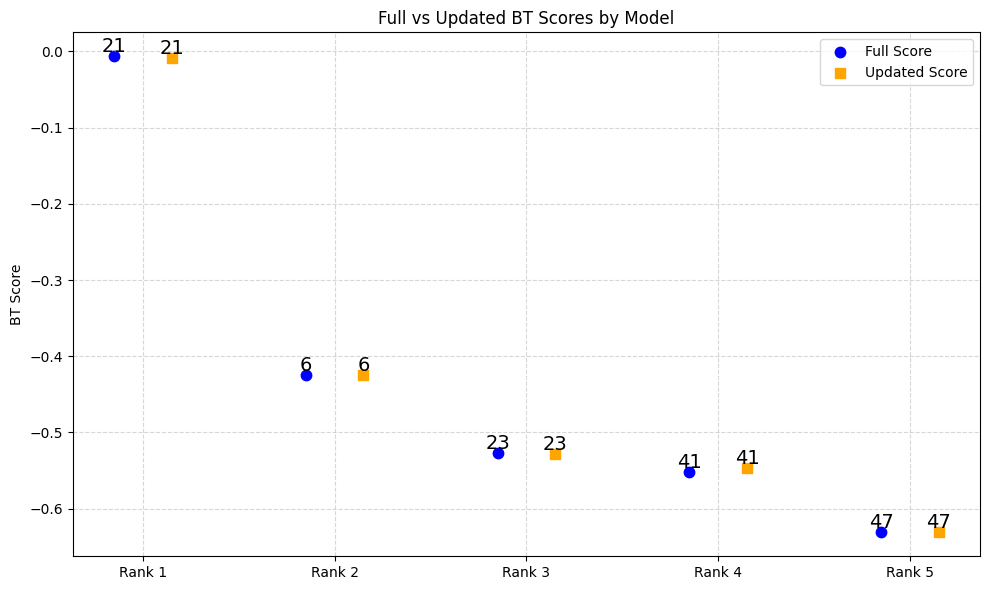

In [54]:
# Unpack data
model_names = [x[0] for x in data]
full_scores = [x[1] for x in data]
updated_scores = [x[2] for x in data]

# X positions
x = np.arange(len(data))
offset = 0.15

# Plotting
plt.figure(figsize=(10, 6))

# Scatter plot for full and updated scores
plt.scatter(x - offset, full_scores, label='Full Score', marker='o', color='blue', s=56)
plt.scatter(x + offset, updated_scores, label='Updated Score', marker='s', color='orange', s=56)

# Annotate each point with the model name
for i in range(len(data)):
    plt.text(x[i] - offset, full_scores[i], str(model_names[i]), ha='center', va='bottom', fontsize=14)
    plt.text(x[i] + offset, updated_scores[i], str(model_names[i]), ha='center', va='bottom', fontsize=14)

# Axis labels and ticks
plt.xticks(x, [f'Rank {i+1}' for i in range(len(data))])
plt.ylabel('BT Score')
plt.title('Full vs Updated BT Scores by Model')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

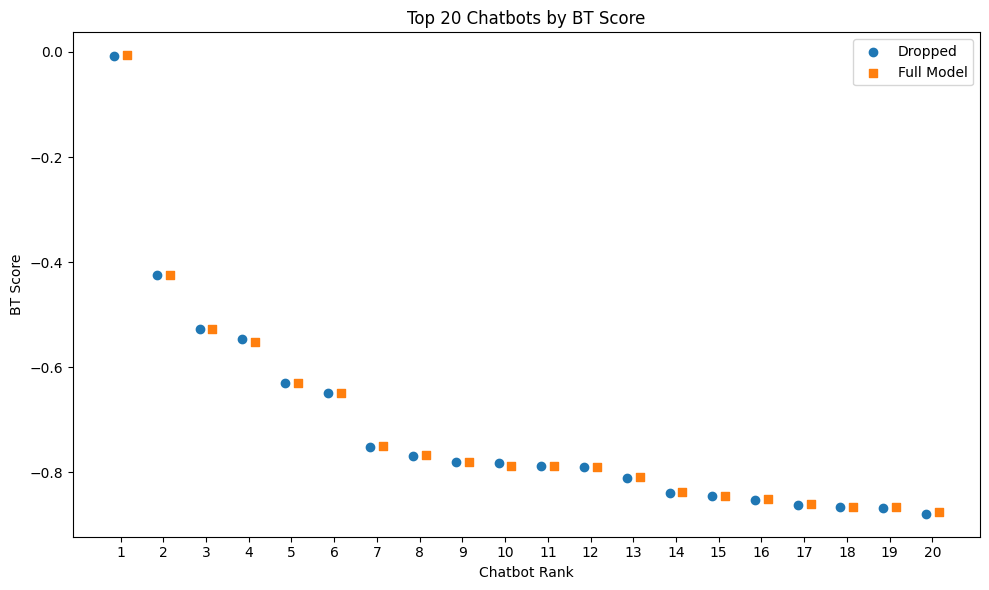

In [34]:
# Sort and take top 20 from each of the full and dropped models.
coefs_full = sorted(model_d.coef_[0], reverse=True)[:20]
coefs_dropped = sorted(model_full.coef_[0], reverse=True)[:20]

# X positions
x = np.arange(20)
offset = 0.15  # small offset to separate the points visually

# Create scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(x - offset, coefs_full, label='Full model', marker='o')
plt.scatter(x + offset, coefs_dropped, label='Dropped model', marker='s')

# Labeling
plt.xlabel('Chatbot Rank')
plt.ylabel('BT Score')
plt.title('Top 20 Chatbots by BT Score')
plt.xticks(x, [f'{i+1}' for i in x])
plt.legend()
plt.tight_layout()
plt.show()

### Inspect the dropped human evals.

In [ ]:
# check the human evals that were dropped to change the top model.


### Simulated Toy Game (for demo purposes).

In [ ]:
# Set seed for reproducibility
np.random.seed(42)

# --- Step 1: Define teams and latent strengths ---
teams = ['A', 'B', 'C', 'D', 'E', 'F']
team_ids = {name: i for i, name in enumerate(teams)}
true_betas = np.array([0.05, 0.04, 0.03, -0.00, -0.01, -0.02])  # (note: we should try out different signal levels later).
num_teams = len(teams)

n_games = 10000
matchups = []

for _ in range(n_games):
    i, j = np.random.choice(6, size=2, replace=False) # randomly choose 2 teams to compete.
    beta_diff = true_betas[i] - true_betas[j]
    prob_win_i = 1 / (1 + np.exp(-beta_diff))
    winner = i if np.random.rand() < prob_win_i else j
    matchups.append((i, j, winner))


X = np.zeros((n_games, 5))  # We fix beta_0 = 0 and estimate beta_1 and beta_2.
y = np.zeros(n_games)

for idx, (i, j, winner) in enumerate(matchups):
    # Map to reduced index space (beta_0 = 0)
    def reduced(k): return k - 1 if k > 0 else None
    
    if winner == i:
        y[idx] = 1
        if reduced(i) is not None:
            X[idx, reduced(i)] += 1
        if reduced(j) is not None:
            X[idx, reduced(j)] -= 1
    else:
        y[idx] = 0
        if reduced(j) is not None:
            X[idx, reduced(j)] += 1
        if reduced(i) is not None:
            X[idx, reduced(i)] -= 1

In [ ]:
myAMIP = LogisticAMIP(X, y, fit_intercept=False, penalty=None)
# inputs: alphaN, player1, player2.
# returns: sign_change_amip, sign_change_refit, original_beta_diff, new_beta_diff_amip, new_beta_diff_refit, indices of top alphaN matches.
results = myAMIP.AMIP_sign_change(40, 0, 1)
print(results)

In [ ]:
k = 1
alphaN = 50
thisPlayerA, thisPlayerB, thisOriginalBetaDiff, thisNewBetaDiff, thisIndices = isRankingRobust(k, alphaN, X, y)

In [ ]:
thisPlayerA, thisPlayerB, thisOriginalBetaDiff,thisNewBetaDiff, thisIndices